# Learning to Throw a Projectile

In this notebook, we demonstrate solver-in-the-loop training using a simple 2D projectile physics example. 

We will tackle an inverse problem (finding the initial throw parameters to hit a target) using both classic optimization and neural networks, highlighting the benefits of integrating physics knowledge into the learning process. 

What you'll see in this notebook:
- Optimize Throw: using gradient descent (autodiff) to find the initial velocity and angle needed to hit a desired target location.
- Learning to Throw: training two neural networks to predict throw parameters from a target location:
    1. Supervised learning using direct input-output pairs (no physics in training).
    2. Differentiable physics learning using a physics-based loss by simulating the trajectory (solver-in-the-loop).
- A simple 2D physics model (constant gravity, no air resistance) with comments on how to extend it (e.g., add air drag or wind).
- Commentary in code and text explaining each step, especially where the physics-based loss is used and why it helps.
- Multimodal solution insight: a visualization and explanation of why the supervised model can fail due to multiple possible solutions, and how the physics-informed approach succeeds.


Let's start by defining our simple physics model for projectile motion.

## Physics Model: 2D Projectile (No Drag)

We'll assume a basic 2D projectile motion:
- Launch from the origin $(0, 0)$ with initial speed $v$ and launch angle $θ$ (degrees).
- Constant downward gravity $g$ (no air resistance, no wind).
- Equations of motion (with time $t$):
$$x(t) = v \cos(\theta) \cdot t$$
$$y(t) = v \sin(\theta) \cdot t - \frac{1}{2} g t^2$$


For simplicity, we'll target an object at ground level (same height as launch). The horizontal **range** (distance traveled when returning to ground $y=0$) is given by the formula:

$$
x_{\text{hit}}(v, \theta) = \frac{v^2 \sin(2 \theta)}{g}
$$ 

Note: This basic model ignores forces like air drag. In the code, we will highlight where one could insert more complex physics (e.g., air resistance) to make the simulation more realistic. The use of PyTorch’s autograd will still allow differentiation even if we replace the simple formula with a more complex numerical solver. 

Let's implement a simple projectile simulator and a function to compute the range.


In [88]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

In [94]:
# Set gravity constant
g = 9.81  # m/s^2

def simulate_throw(v, angle) -> torch.Tensor:
    """
    Compute the horizontal range of a projectile launched with 
    speed v (m/s) and angle (radians) from ground (y=0) back to
     ground, ignoring air resistance.
    """
    # v and angle can be torch tensors (for autograd)
    v = torch.as_tensor(v)
    angle = torch.as_tensor(angle)
    return (v**2 * torch.sin(2*angle)) / g

def simulate_throw_trajectory(v, angle, g=9.81, num_points=100):
    """
    Simulate a projectile trajectory launched from ground (y=0) 
    with initial speed v (m/s) and launch angle (radians).
    
    Returns: t, x(t), y(t)
    """
    v, angle = torch.as_tensor(v), torch.as_tensor(angle)
    # Compute time-of-flight: 
    # T = 2*v*sin(angle) / g (assuming launch and landing at y=0)
    T = 2 * v * torch.sin(angle) / g
    t = torch.linspace(0, T, num_points)
    x = v * torch.cos(angle) * t
    y = v * torch.sin(angle) * t - 0.5 * g * t**2
    return t, x, y

# Placeholder for more complex physics (not used in this simple demo):
# def simulate_with_drag(v, angle):
#     # Here you could integrate equations of motion with air drag or wind.
#     # For example, use small time steps to update velocity with drag force and position.
#     # This function is left as a placeholder to show where extended physics could be added.
#     raise NotImplementedError("Drag simulation not implemented in this demo")

# Quick test of the range function (should be ~ maximum at 45 degrees):
v_test = torch.tensor(20.0)
for ang in [0, 30, 45, 60, 90]:
    ang_rad = torch.tensor(math.radians(ang))
    x_hit = simulate_throw(v_test, ang_rad)
    print(f"Angle {ang}° -> lands at approximately {x_hit.item():.2f} m away; (x, y) = ({x_hit.item():.2f}, 0)")

Angle 0° -> lands at approximately 0.00 m away; (x, y) = (0.00, 0)
Angle 30° -> lands at approximately 35.31 m away; (x, y) = (35.31, 0)
Angle 45° -> lands at approximately 40.77 m away; (x, y) = (40.77, 0)
Angle 60° -> lands at approximately 35.31 m away; (x, y) = (35.31, 0)
Angle 90° -> lands at approximately -0.00 m away; (x, y) = (-0.00, 0)


Note: We expect the maximum range at 45°, and zero range at 0° (horizontal throw with no height) and 90° (vertical throw). 

So far, so good.

## 1. Optimize Throw (Inverse Problem via AutoDiff)

Now let's solve an **inverse problem**:  

**Goal**: Given a target location (here, a horizontal distance on the ground), find $v$ and $\theta$ such that the range/hit position $x_{\text{hit}}(v, \theta)$ equals the target distance.

We'll use PyTorch's autodiff to solve this by treating the initial velocity $v$ and angle $\theta$ as variables with gradients and performing gradient descent on the error between the projectile's landing position and the target:

We run a simple gradient descent loop to minimize the squared error: 

$$
L(x_{\text{predicted}}, x_{\text{target}}) = (x_{\text{predicted}} - x_{\text{target}})^2
$$

We can also write this as:

$$
L\big( x(v, \theta), \hat{x} \big) = \big( x(v, \theta) - \hat{x} \big)^2,
$$

where 

$$
x(v, \theta) = \mathcal{P}(v, \theta) = \frac{v^2 \sin(2 \theta)}{g}
$$

is our "physical simulation". You can imagine that this could be some time stepping scheme with more operation.

Utilizing the chain rule, our automatic differentation first computes 

$$
\frac{\partial L}{\partial x} 
= 2 \big( x(v, \theta) - \hat{x} \big).
$$

Next, we need the derivatives of $x(v, \theta)$ w.r.t. $v$ and $\theta$: 

$$
\frac{\partial x}{\partial v} = \frac{\partial}{\partial v} 
\left( 
    \frac{v^2 \sin(2 \theta)}{g}
\right) =
\frac{2 v \sin(2\theta)}{g}
$$

$$
\frac{\partial x}{\partial \theta} 
= \frac{\partial}{\partial \theta} 
\left( 
    \frac{v^2 \sin(2 \theta)}{g}
\right)
=
\frac{v^2 \cdot 2\cos(2\theta)}{g}
=
\frac{2v^2 \cos(2\theta)}{g}
$$
Putting it together for the chain rule:
$$
\frac{\partial L}{\partial v}
=
\frac{\partial L}{\partial x}
\cdot
\frac{\partial x}{\partial v}
=
2 (x(v, \theta)- \hat{x})
\cdot
\frac{2v \sin(2\theta)}{g}
$$

And you can calculate 

$$
\frac{\partial L}{\partial \theta}
= \frac{\partial L}{\partial x}
\cdot \frac{\partial x}{\partial \theta}
$$

As usual, on each iteration, we:
- Forward simulation: compute the projectile hit with current $v$ and $\theta$.
- Compute the loss.
- Use `.backward()` to get gradient for updating $v$ and $\theta$ using some gradient-descent based optimizer.
- (Optionally, we could restrict ourselves to shooting towards the positive x-axis by clamping $v$ to be non-negative and $\theta \in [0, 90°]$.)

In [95]:
# Set up target.
# Desired target location 
# (horizontal distance in meters, target is on ground at y=0)
target_x = 30.0  # meters away

# Initialize v and angle with some guesses
# initial guess for speed (m/s)
v = torch.tensor(10.0, requires_grad=True)  
# initial guess for angle (20 degrees in radians)
angle = torch.tensor(20.0 * 3.14159/180.0, requires_grad=True)  

print(f"Initial guess: v={v.item():.1f} m/s, angle={math.radians(angle.item()):.1f}°")

optimizer = torch.optim.Adam([v, angle], lr=0.1)

epochs = 201
for i in range(epochs):
    optimizer.zero_grad()
    
    # Compute x_hit for current v and angle
    x_hit_curr = simulate_throw(v, angle)
     # squared distance error
    loss = (x_hit_curr - target_x)**2
    # compute gradients w.rt `v` and `angle`
    loss.backward()
    # gradient descent step
    optimizer.step()
    
    # Print progress every 20 iterations
    if i % 20 == 0:
        print(f"Iter {i:3d}: "
              f"x_hit={x_hit_curr.item():.2f}, "
              f"loss={loss.item():.2f}, "
              f"v={v.item():.2f}, "
              f"angle={angle.item()*180/3.14159:.2f}°"
              )

# Final solution
x_hit_final = simulate_throw(v, angle).item()
print(f"\nFinal solution: "
      f"v={v.item():.2f} m/s, "
      f"angle={angle.item()*180/3.14159:.2f}°, "
      f"x_hit_final={x_hit_final:.2f} m (target: {target_x} m)")


Initial guess: v=10.0 m/s, angle=0.0°
Iter   0: x_hit=6.55, loss=549.79, v=10.10, angle=25.73°
Iter  20: x_hit=14.45, loss=241.72, v=12.11, angle=39.27°
Iter  40: x_hit=19.82, loss=103.61, v=14.04, angle=43.84°
Iter  60: x_hit=24.72, loss=27.92, v=15.64, angle=45.39°
Iter  80: x_hit=28.27, loss=3.00, v=16.69, angle=45.19°
Iter 100: x_hit=29.89, loss=0.01, v=17.14, angle=45.17°
Iter 120: x_hit=30.19, loss=0.04, v=17.21, angle=45.09°
Iter 140: x_hit=30.07, loss=0.01, v=17.17, angle=45.13°
Iter 160: x_hit=30.00, loss=0.00, v=17.15, angle=45.16°
Iter 180: x_hit=29.99, loss=0.00, v=17.15, angle=45.16°
Iter 200: x_hit=30.00, loss=0.00, v=17.16, angle=45.16°

Final solution: v=17.16 m/s, angle=45.16°, x_hit_final=30.00 m (target: 30.0 m)


## Optional: Verify with an explicit forward simulation

In [96]:
# Simple simulation of trajectory for the final solution (small time steps)
v_val = v.detach().item()
angle_val = angle.detach().item()
dt = 0.01
x, y = 0.0, 0.0
traj = [(x, y)]
vy = v_val * np.sin(angle_val)
vx = v_val * np.cos(angle_val)
while y >= 0.0:
    # update position
    x += vx * dt
    y += vy * dt
    # update vertical velocity
    vy -= g * dt
    traj.append((x, max(y, 0.0)))  # don't go below ground
    
# Check final landing position
print(f"Projectile landed at x = {traj[-1][0]:.2f} m (target {target_x} m).")


Projectile landed at x = 30.12 m (target 30.0 m).


# 2. Learning to Throw (Neural Network Inverse Solver)

Now, let's train neural networks to **learn** the inverse mapping from target location to initial throw parameters. We will compare two training approaches:

- 2.1 Supervised Training on example pairs of $x_{\text{target}} \to [v, \theta]$
- 2.2 Differentiable Physics Training: Train a network without directly providing the "expected" outputs $[v, \theta]$. Instead, for each target, we use the physics simulation in the loss: the network's predicted $[v, \theta]$ is fed into the projection model, and we compare the resulting landing position with the target. We rely on the differentiability of the physics simulation to guide the training. This is "solver-in-the-loop" training.

By comparing these, we'll see how embedding the physics knowledge can improve learning, especially when 
- (a) we don't have explicit input-output value pairs (and we don't want to (or cannot) rely on generating them synthetically)
- (b) the problem to solve is ambiguous or multi-valued 

## 2.1 Supervised Training

### Prepare the training data

In [107]:
# Generate training data
torch.manual_seed(0)
N = 300  # number of training examples
train_inputs = []
train_outputs = []  # true [v, angle] for supervised learning

for _ in range(N):
    # Random initial speed (5 to 40 m/s) and angle (5° to 85°)
    v_target = np.random.uniform(5, 40)
    angle_target_deg = np.random.uniform(5, 85)
    angle_target_rad = math.radians(angle_target_deg)
    # Simulate target landing distance
    x_target = simulate_throw(v_target, angle_target_rad)
    
    # Save input (x_target, y_target) and output (v, angle)
    # Note: target y is 0 (ground)
    train_inputs.append([x_target, 0.0])
    train_outputs.append([v_target, angle_target_deg])

train_inputs = torch.tensor(train_inputs, dtype=torch.float)
train_outputs = torch.tensor(train_outputs, dtype=torch.float)
print("Sample train input (target_x, target_y) and output (v, angle_deg):")
for i in range(3):
    print(f"  Input: {train_inputs[i].tolist()}, Output: {train_outputs[i].tolist()}")

Sample train input (target_x, target_y) and output (v, angle_deg):
  Input: [27.063873291015625, 0.0], Output: [28.840560913085938, 9.307024002075195]
  Input: [30.713184356689453, 0.0], Output: [27.95953369140625, 78.66510009765625]
  Input: [22.551931381225586, 0.0], Output: [28.775646209716797, 82.25176239013672]


Notice how we used random initial throws to generate our ground truth data. This means that the mapping from target distance to throw parameters is not one-to-one (the same distance could appear from different throws). In these cases, our supervised model has no further understanding of the problem and will try to fit an average in such cases. 

### Define the Neural Network (NN) model

In [108]:
# Define a simple feed-forward NN for the inverse problem
class ThrowNet(nn.Module):
    def __init__(self):
        super(ThrowNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), 
            nn.ReLU(),
            nn.Linear(32, 32), 
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        # x is shape (batch, 2) containing [target_x, target_y]
        prediction = self.net(x)
        v_out = prediction[..., 0]
        angle_out = prediction[..., 1]  
        # Output: shape (N, 2): [[v, deg], ..., [v, deg]]
        return torch.stack([v_out, angle_out], dim=-1)

# Instantiate the exact same network for each training method:
net_supervised = ThrowNet()
net_physics    = ThrowNet()

## 2.1 Supervised Training

Loss function:

$$
L_{\text{sup}} = \frac{1}{N}\sum ||[v_{\text{pred}}, \theta_{\text{pred}}] - [v_{\text{true}}, \theta_{\text{true}}]||^2
$$

In [128]:
# Training parameters
epochs = 5000
lr = 0.01
optimizer = torch.optim.Adam(net_supervised.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training loop for supervised learning
loss_history_sup = []
for epoch in range(epochs):
    net_supervised.train()
    optimizer.zero_grad()
    preds = net_supervised(train_inputs)
    loss = criterion(preds, train_outputs)  # compare to true v, angle
    loss.backward()
    optimizer.step()
    loss_history_sup.append(loss.item())
    # (Optional) stop early if very low loss
    if loss.item() < 1e-4:
        print(f"Stopeed early at epoch {epoch}")
        break

print(f"Supervised training final loss: {loss.item():.4f}")

Supervised training final loss: 262.7617


## Differentiable Physics Training

In [129]:
# Training loop for physics-based learning
optimizer = torch.optim.Adam(net_physics.parameters(), lr=lr)
loss_history_phys = []

for epoch in range(epochs):
    net_physics.train()
    optimizer.zero_grad()
    # Predict initial conditions
    preds = net_physics(train_inputs)            # shape (N, 2) -> [v_pred, angle_pred_deg]
    v_pred = preds[:, 0]
    angle_pred_deg = preds[:, 1]
    # Convert angle to radians for physics calculation
    angle_pred = angle_pred_deg * 3.14159/180.0
    # Simulate (compute range) using differentiable physics model
    pred_range = simulate_throw(v_pred, angle_pred)
    target_x = train_inputs[:, 0]  # the first column is target distance
    # Compute physics-based loss (how far from target)
    loss = torch.mean((pred_range - target_x)**2)
    loss.backward()
    optimizer.step()
    loss_history_phys.append(loss.item())
    if loss.item() < 1e-4:
        break

print(f"Differentiable physics training final loss: {loss.item():.4f}")

Differentiable physics training final loss: 0.0831


## Results: Which model learned to throw better?

In [132]:
# Evaluate both models on the training data
net_supervised.eval()
net_physics.eval()
with torch.no_grad():
    preds_sup = net_supervised(train_inputs)
    preds_phys = net_physics(train_inputs)

# Function to compute landing error for a batch of predictions
def landing_errors(preds, inputs):
    v_pred = preds[:, 0]
    angle_pred_deg = preds[:, 1]
    angle_pred = angle_pred_deg * 3.14159/180.0
    pred_range = simulate_throw(v_pred, angle_pred)
    target_x = inputs[:, 0]
    # error distance between where it landed and target
    return (pred_range - target_x)

errors_sup = landing_errors(preds_sup, train_inputs)
errors_phys = landing_errors(preds_phys, train_inputs)

# Compute average absolute error
avg_err_sup = torch.mean(torch.abs(errors_sup)).item()
avg_err_phys = torch.mean(torch.abs(errors_phys)).item()
print(f"Mean landing error - Supervised model: {avg_err_sup:.2f} m, Physics model: {avg_err_phys:.2f} m")


Mean landing error - Supervised model: 15.05 m, Physics model: 0.08 m


In [133]:
# Pick a specific target (maybe one from the data or a new one)
test_target = torch.tensor([[25.0, 0.0]])  # target at 25 m
with torch.no_grad():
    out_sup = net_supervised(test_target)
    out_phys = net_physics(test_target)
v_sup, angle_sup = out_sup[0,0].item(), out_sup[0,1].item()
v_phys, angle_phys = out_phys[0,0].item(), out_phys[0,1].item()
print(f"For target 25m, Supervised model predicts v={v_sup:.2f}, angle={angle_sup:.2f}°")
print(f"For target 25m, Physics model predicts   v={v_phys:.2f}, angle={angle_phys:.2f}°")

# How far do they actually throw?
rang_sup = (v_sup**2 * math.sin(2*math.radians(angle_sup))) / g
rang_phys = (v_phys**2 * math.sin(2*math.radians(angle_phys))) / g
print(f"Supervised model lands at ~{rang_sup:.1f} m (error {rang_sup-25:.1f} m)")
print(f"Physics model lands at ~{rang_phys:.1f} m (error {rang_phys-25:.1f} m)")

For target 25m, Supervised model predicts v=21.42, angle=48.50°
For target 25m, Physics model predicts   v=18.70, angle=22.31°
Supervised model lands at ~46.4 m (error 21.4 m)
Physics model lands at ~25.0 m (error 0.0 m)


## Plot the results

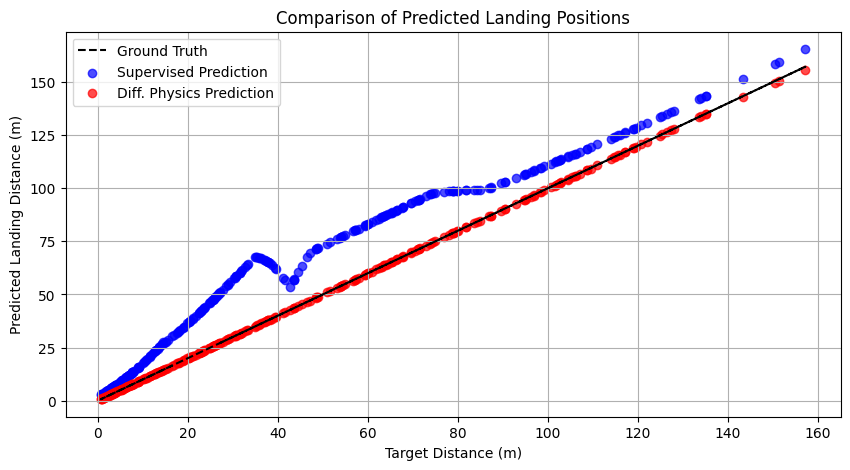

In [134]:
# Evaluate the two models on the training inputs
net_supervised.eval()
net_physics.eval()
with torch.no_grad():
    # outputs: [v_pred, angle_pred (in degrees)]
    preds_sup = net_supervised(train_inputs)  
    preds_phys = net_physics(train_inputs)

# Extract predicted v and angles, converting angles from degrees to radians
v_sup = preds_sup[:, 0]
angle_sup = preds_sup[:, 1] * math.pi / 180.0

v_phys = preds_phys[:, 0]
angle_phys = preds_phys[:, 1] * math.pi / 180.0

# Compute the predicted landing positions using our physics simulation
pred_range_sup = (v_sup**2 * torch.sin(2*angle_sup)) / g
pred_range_phys = (v_phys**2 * torch.sin(2*angle_phys)) / g

# Ground truth target distances (first column of train_inputs)
target_x = train_inputs[:, 0]

# Convert tensors to numpy arrays for plotting (if necessary)
target_x_np = target_x.detach().cpu().numpy()
pred_range_sup_np = pred_range_sup.detach().cpu().numpy()
pred_range_phys_np = pred_range_phys.detach().cpu().numpy()

plt.figure(figsize=(10, 5))
# Plot the ideal line (ground truth)
plt.plot(target_x_np, target_x_np, 'k--', label='Ground Truth')
# Scatter predicted landing positions for both methods
plt.scatter(target_x_np, pred_range_sup_np, label='Supervised Prediction', color='blue', alpha=0.7)
plt.scatter(target_x_np, pred_range_phys_np, label='Diff. Physics Prediction', color='red', alpha=0.7)
plt.xlabel('Target Distance (m)')
plt.ylabel('Predicted Landing Distance (m)')
plt.title('Comparison of Predicted Landing Positions')
plt.legend()
plt.grid(True)
plt.show()

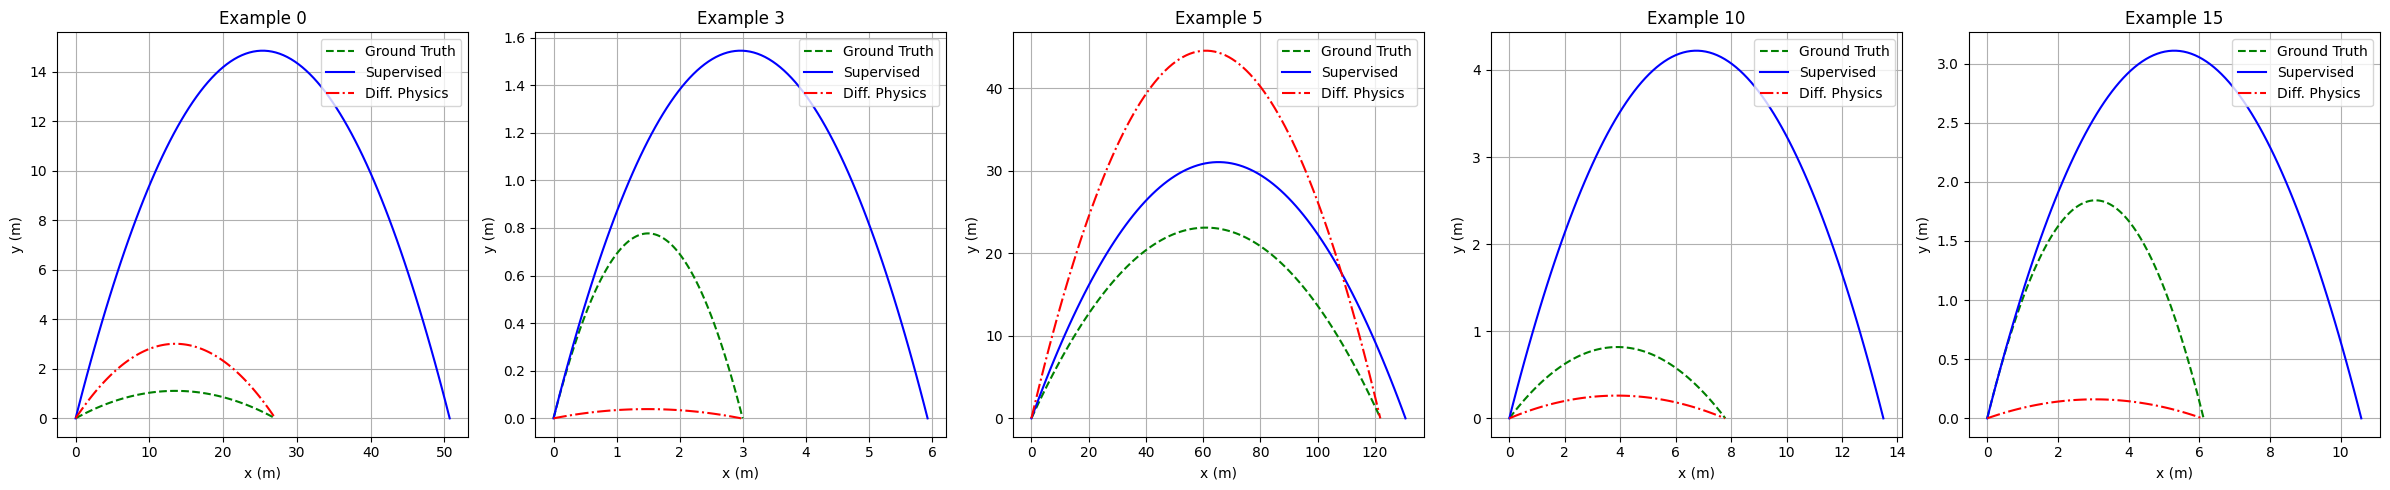

In [135]:
# Choose a couple of examples from your training data
example_indices = [0, 3, 5, 10, 15]

# Ensure the models are in evaluation mode and predictions are computed:
net_supervised.eval()
net_physics.eval()
with torch.no_grad():
    preds_sup = net_supervised(train_inputs)   # shape (N, 2) => [v, angle (deg)]
    preds_phys = net_physics(train_inputs)

plt.figure(figsize=(24, 5))
for j, idx in enumerate(example_indices):
    # Ground truth parameters from training data (angle stored in degrees)
    true_v = train_outputs[idx, 0].item()
    true_angle = train_outputs[idx, 1].item() * math.pi / 180.0  # convert to radians
    _, x_true, y_true = simulate_throw_trajectory(true_v, true_angle)
    
    # Supervised model predictions
    sup_v = preds_sup[idx, 0].item()
    sup_angle = preds_sup[idx, 1].item() * math.pi / 180.0  # convert to radians
    _, x_sup, y_sup = simulate_throw_trajectory(sup_v, sup_angle)
    
    # Diff. Physics model predictions
    phys_v = preds_phys[idx, 0].item()
    phys_angle = preds_phys[idx, 1].item() * math.pi / 180.0  # convert to radians
    _, x_phys, y_phys = simulate_throw_trajectory(phys_v, phys_angle)
    
    # Plot each example in a subplot
    plt.subplot(1, len(example_indices), j+1)
    plt.plot(x_true.numpy(), y_true.numpy(), 'g--', label='Ground Truth')
    plt.plot(x_sup.numpy(), y_sup.numpy(), 'b-', label='Supervised')
    plt.plot(x_phys.numpy(), y_phys.numpy(), 'r-.', label='Diff. Physics')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Example {idx}')
    plt.legend(loc="upper right")
    plt.grid(True)

plt.tight_layout()
plt.show()


# Check generalization: can they throw towards the left? (negative y)

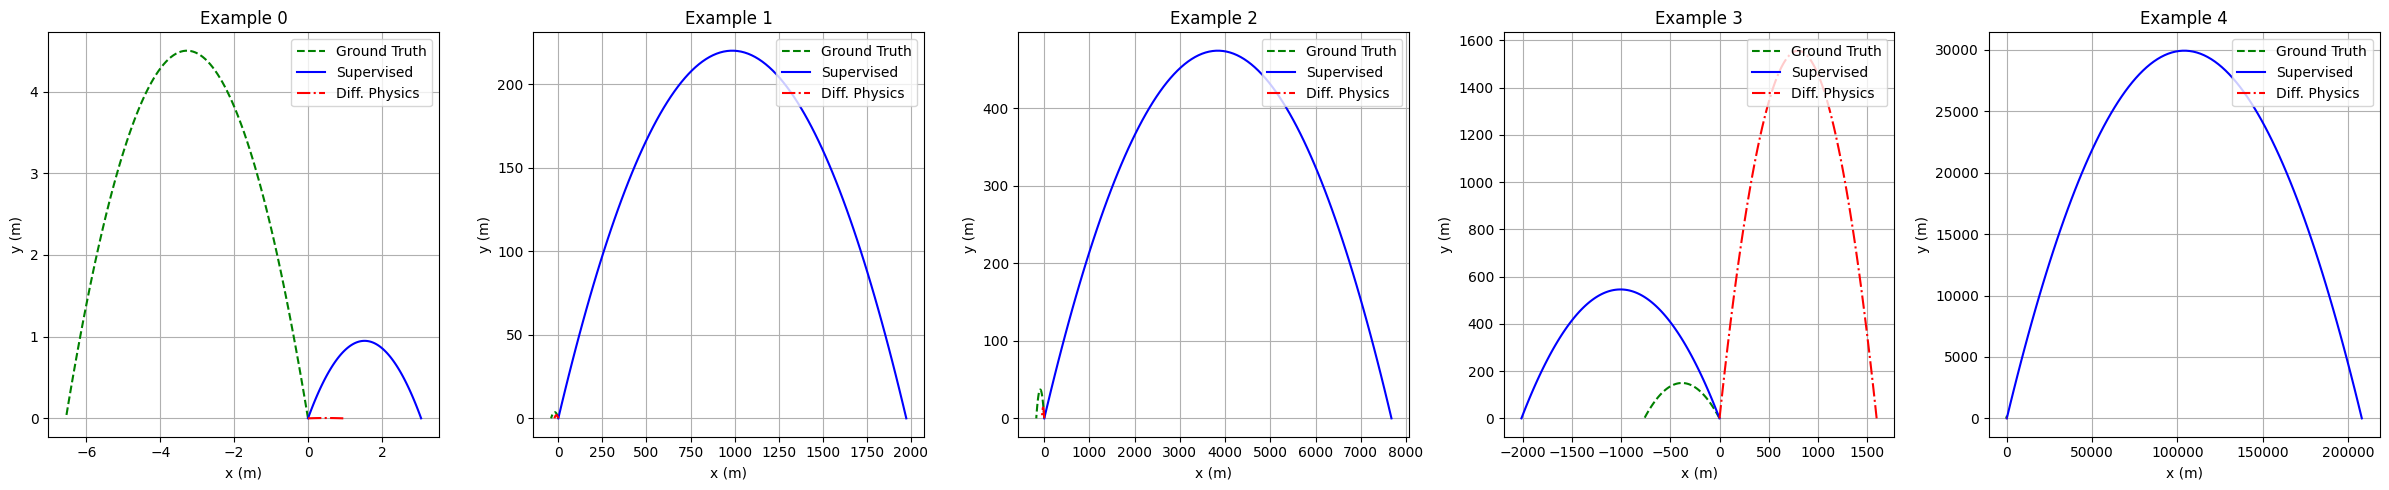

In [143]:
# [[v, angle in deg]]
example_left_initial_params = torch.tensor([
    [10, 110],
    [25, 160],
    [42, 140],
    [88, 142],
    [55, 100]
])

# [[x_target, y_target], ...]
example_left_targets = []
for v, angle in example_left_initial_params:
    x_target = simulate_throw(v, angle)
    example_left_targets.append([x_target.item(), 0.0])
# Convert the list to a tensor.
example_left_targets = torch.tensor(example_left_targets, dtype=torch.float)

# Ensure the models are in evaluation mode and predictions are computed:
net_supervised.eval()
net_physics.eval()
with torch.no_grad():
    preds_sup_left = net_supervised(example_left_targets)   # shape (N, 2) => [v, angle (deg)]
    preds_phys_left = net_physics(example_left_targets)

plt.figure(figsize=(24, 5))
for i, initial_param in enumerate(example_left_initial_params):
    # Ground truth parameters from training data (angle stored in degrees)
    true_v = initial_param[0]
    true_angle = initial_param[1] * torch.pi / 180.0  # convert to radians
    _, x_true, y_true = simulate_throw_trajectory(true_v, true_angle)
    
    # Supervised model predictions
    sup_v = preds_sup_left[i, 0].item()
    sup_angle = preds_sup_left[i, 1].item() * math.pi / 180.0  # convert to radians
    _, x_sup, y_sup = simulate_throw_trajectory(sup_v, sup_angle)
    
    # Diff. Physics model predictions
    phys_v = preds_phys_left[i, 0].item()
    phys_angle = preds_phys_left[i, 1].item() * math.pi / 180.0  # convert to radians
    _, x_phys, y_phys = simulate_throw_trajectory(phys_v, phys_angle)
    
    # Plot each example in a subplot
    plt.subplot(1, len(example_indices), i+1)
    plt.plot(x_true.numpy(), y_true.numpy(), 'g--', label='Ground Truth')
    plt.plot(x_sup.numpy(), y_sup.numpy(), 'b-', label='Supervised')
    plt.plot(x_phys.numpy(), y_phys.numpy(), 'r-.', label='Diff. Physics')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title(f'Example {i}')
    plt.legend(loc="upper right")
    plt.grid(True)

plt.tight_layout()
plt.show()
